<a href="https://colab.research.google.com/github/raushan-kumar7/neural-style-transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

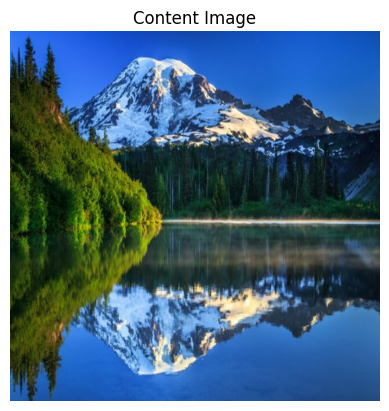

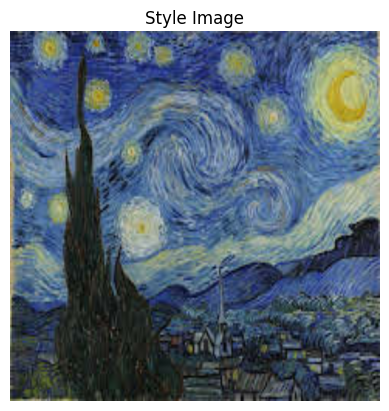

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 1000, 1000, 3))
  warnings.warn(msg)


Epoch 0/100 - Loss: 2.710948944091797
Epoch 20/100 - Loss: 94.83475494384766
Epoch 40/100 - Loss: 44.70463180541992
Epoch 60/100 - Loss: 32.395591735839844
Epoch 80/100 - Loss: 28.92618179321289


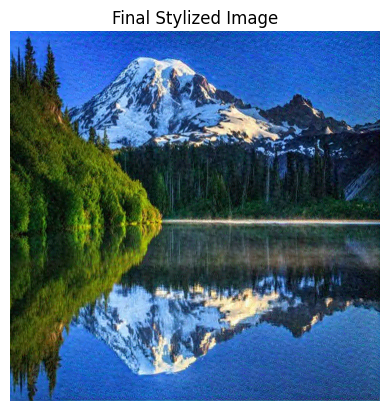

✅ Image saved as 'stylized_output.jpg' 🎉


In [ ]:
# Install required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras.applications import vgg19

# Function to load and preprocess images
def load_and_process_image(image_path):
    max_dim = 1000  # Resize to speed up training
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    img = tf.image.resize(img, (max_dim, max_dim))  # Resize to (400,400)
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

# Function to display images
def show_image(image, title=None):
    img = np.squeeze(image, axis=0)  # Remove batch dimension
    img = np.clip(img, 0, 1)  # Ensure values are between 0-1
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Load content and style images
content_path = "/content/content.jpg"  # Upload your content image
style_path = "/content/style.jpg"  # Upload your style image

content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# Display content and style images
show_image(content_image, "Content Image")
show_image(style_image, "Style Image")

# Load VGG19 Model (without top layers)
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False  # Freeze the model

# Extract intermediate layers for style & content
content_layers = ['block5_conv2']  # Best layer for content extraction
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Style layers

num_style_layers = len(style_layers)

# Function to get layer outputs from VGG19
def get_model():
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    matrix = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(matrix, matrix, transpose_a=True)
    return gram / tf.cast(tf.shape(matrix)[0], tf.float32)

def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Function to compute total loss
def compute_loss(model, loss_weights, generated_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    outputs = model(generated_image)

    style_output_features = outputs[:num_style_layers]
    content_output_features = outputs[num_style_layers:]

    content_score = content_loss(content_output_features[0], content_features[0])
    style_score = sum(style_loss(style_output, gram_target) for style_output, gram_target in zip(style_output_features, gram_style_features))

    style_score /= num_style_layers
    total_loss = (style_weight * style_score) + (content_weight * content_score)
    return total_loss

# Load model
model = get_model()

# Extract style and content features
style_features = [style_layer.numpy() for style_layer in model(style_image)[:num_style_layers]]
content_features = [content_layer.numpy() for content_layer in model(content_image)[num_style_layers:]]

# Convert style features to gram matrices
gram_style_features = [gram_matrix(feature) for feature in style_features]

# Training settings
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=0.02)
style_weight = 1e-2
content_weight = 1e4
epochs = 100 # You can reduce this for faster results

# Training step function
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, (style_weight, content_weight), generated_image, gram_style_features, content_features)
    grad = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
    return loss

# Train the model
for epoch in range(epochs):
    loss = train_step(generated_image)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.numpy()}")

# Display the final generated image
show_image(generated_image, "Final Stylized Image")

# Save the generated image
generated_image_np = np.squeeze(generated_image.numpy(), axis=0)
generated_image_np = (generated_image_np * 255).astype(np.uint8)
cv2.imwrite("stylized_output.jpg", cv2.cvtColor(generated_image_np, cv2.COLOR_RGB2BGR))

print("✅ Image saved as 'stylized_output.jpg' 🎉")